# Multi-Head Attention

**Running parallel attention heads to capture different relationships**

## Why Multiple Heads?

A single attention head computes one set of attention weights. But language has many simultaneous relationships:

Consider: "The cat that I saw yesterday sat on the mat."

When processing "sat", the model might want to:
- Attend to "cat" (the subject)
- Attend to "mat" (the object)
- Attend to "yesterday" (temporal context)
- Attend to "I" (who's involved)

A single attention head can only produce one weighted combination. It might strongly attend to the subject but miss the object.

**Multi-head attention** solves this by running multiple attention operations in parallel, each with its own learned projections. Each head can specialize in different relationships:

| Head | Might Learn To Focus On |
|------|-------------------------|
| Head 0 | Syntactic structure (subject-verb) |
| Head 1 | Semantic similarity |
| Head 2 | Positional patterns (adjacent words) |
| Head 3 | Long-range dependencies |

It's like having multiple experts examine the same data from different angles, then combining their insights.

## The Architecture

Multi-head attention works as follows:

1. **Project** the input to Q, K, V for each head (using separate learned weights)
2. **Compute attention** independently in each head
3. **Concatenate** all head outputs
4. **Project** back to the original dimension

Mathematically:

$$\text{MultiHead}(X) = \text{Concat}(\text{head}_1, ..., \text{head}_h) W_O$$

where each head is:

$$\text{head}_i = \text{Attention}(XW_Q^i, XW_K^i, XW_V^i)$$

**Key insight**: We don't just run $h$ copies of full-dimension attention. Instead, we split the embedding dimension across heads:

$$d_k = d_{model} / h$$

With $d_{model} = 256$ and $h = 4$ heads, each head operates on 64 dimensions. The total computation is similar to single-head attention, but with multiple specialized views.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head self-attention mechanism.
    
    Runs multiple attention heads in parallel, each with its own
    Q, K, V projections. Outputs are concatenated and projected.
    """
    
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension per head
        
        # Linear projections for Q, K, V, and output
        # These are d_model → d_model, but we'll reshape to separate heads
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(
        self, 
        x: torch.Tensor, 
        mask: torch.Tensor = None
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            x: (batch, seq_len, d_model) - input embeddings
            mask: optional causal mask
        
        Returns:
            output: (batch, seq_len, d_model)
            attention_weights: (batch, num_heads, seq_len, seq_len)
        """
        batch_size, seq_len, _ = x.shape
        
        # 1. Linear projections
        Q = self.W_q(x)  # (batch, seq_len, d_model)
        K = self.W_k(x)
        V = self.W_v(x)
        
        # 2. Reshape to (batch, num_heads, seq_len, d_k)
        # This splits d_model into num_heads × d_k
        Q = Q.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        
        # 3. Scaled dot-product attention (for all heads in parallel)
        # scores: (batch, num_heads, seq_len, seq_len)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        if mask is not None:
            # Expand mask for heads dimension
            scores = scores.masked_fill(mask, float('-inf'))
        
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # 4. Apply attention to values
        # context: (batch, num_heads, seq_len, d_k)
        context = torch.matmul(attention_weights, V)
        
        # 5. Concatenate heads: (batch, seq_len, d_model)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        
        # 6. Final projection
        output = self.W_o(context)
        
        return output, attention_weights

## Understanding the Reshape

The key trick is reshaping the projections to separate the heads. Let's trace through:

```
Input x: (batch, seq_len, d_model)
         (2,     8,       256)
             ↓
         W_q projection
             ↓
Q:       (batch, seq_len, d_model)
         (2,     8,       256)
             ↓
         view as (batch, seq_len, num_heads, d_k)
             ↓
Q:       (2, 8, 4, 64)
             ↓
         transpose(1, 2) - swap seq_len and num_heads
             ↓
Q:       (batch, num_heads, seq_len, d_k)
         (2,     4,         8,       64)
```

Now each head operates on its own 64-dimensional subspace. The batch matrix multiply computes all heads in parallel.

In [3]:
# Let's trace through the shapes
d_model = 256
num_heads = 4
d_k = d_model // num_heads
batch_size = 2
seq_len = 8

print(f"Configuration:")
print(f"  d_model = {d_model}")
print(f"  num_heads = {num_heads}")
print(f"  d_k = d_model / num_heads = {d_k}")
print()

# Input
x = torch.randn(batch_size, seq_len, d_model)
print(f"Input x: {x.shape}")

# Project to Q (for demonstration)
W_q = nn.Linear(d_model, d_model, bias=False)
Q = W_q(x)
print(f"After W_q projection: {Q.shape}")

# Reshape for multi-head
Q_reshaped = Q.view(batch_size, seq_len, num_heads, d_k)
print(f"After view: {Q_reshaped.shape}")

# Transpose for attention
Q_final = Q_reshaped.transpose(1, 2)
print(f"After transpose: {Q_final.shape}")
print(f"  → (batch, num_heads, seq_len, d_k)")

Configuration:
  d_model = 256
  num_heads = 4
  d_k = d_model / num_heads = 64

Input x: torch.Size([2, 8, 256])
After W_q projection: torch.Size([2, 8, 256])
After view: torch.Size([2, 8, 4, 64])
After transpose: torch.Size([2, 4, 8, 64])
  → (batch, num_heads, seq_len, d_k)


In [4]:
# Test the full multi-head attention
mha = MultiHeadAttention(d_model=256, num_heads=4, dropout=0.0)

# Input
x = torch.randn(2, 8, 256)

# Causal mask
mask = torch.triu(torch.ones(8, 8), diagonal=1).bool()

# Forward
output, attn_weights = mha(x, mask=mask)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")
print(f"  → (batch, num_heads, seq_len, seq_len)")

Input shape: torch.Size([2, 8, 256])
Output shape: torch.Size([2, 8, 256])
Attention weights shape: torch.Size([2, 4, 8, 8])
  → (batch, num_heads, seq_len, seq_len)


## Visualizing Different Heads

Each head learns different attention patterns. Let's visualize them:

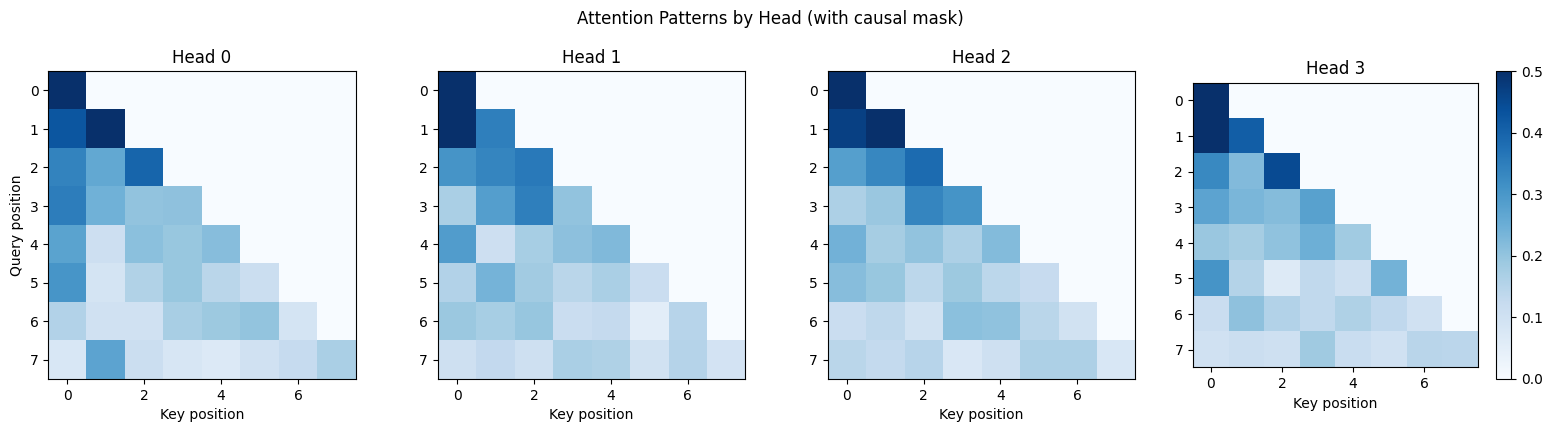

Note: These are random (untrained) weights.
In a trained model, each head would show distinct patterns.


In [5]:
# Visualize attention patterns for each head
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for head_idx in range(4):
    ax = axes[head_idx]
    weights = attn_weights[0, head_idx].detach().numpy()
    
    im = ax.imshow(weights, cmap='Blues', vmin=0, vmax=0.5)
    ax.set_title(f'Head {head_idx}')
    ax.set_xlabel('Key position')
    if head_idx == 0:
        ax.set_ylabel('Query position')
    
    # Add colorbar to last plot
    if head_idx == 3:
        plt.colorbar(im, ax=ax)

plt.suptitle('Attention Patterns by Head (with causal mask)', y=1.02)
plt.tight_layout()
plt.show()

print("Note: These are random (untrained) weights.")
print("In a trained model, each head would show distinct patterns.")

## What Trained Heads Learn

Research on trained transformers has identified several common head types:

| Pattern | What It Does | Example |
|---------|-------------|---------|
| **Previous token** | Always attends to position $i-1$ | Bigram-like patterns |
| **Beginning of sequence** | Attends to first token | Often a "null" or default attention |
| **Positional** | Attends to specific relative positions | Fixed offsets |
| **Induction** | Copies patterns: if "AB...A" seen, attend to B | In-context learning |
| **Syntactic** | Subject-verb, noun-adjective | Grammar structure |

The model figures out which patterns are useful during training. We don't program them in—they emerge from the data.

## The Output Projection

After concatenating head outputs, we apply one more linear transformation $W_O$:

$$\text{output} = \text{Concat}(\text{head}_1, ..., \text{head}_h) W_O$$

Why this final projection?

1. **Mixing information across heads**: The concatenated output has information from all heads, but in separate "slots". $W_O$ lets the model combine insights from different heads.

2. **Learned recombination**: Maybe head 0's "subject" information should be combined with head 2's "semantic" information. $W_O$ learns these combinations.

3. **Consistent interface**: The output has the same dimension as the input ($d_{model}$), which is needed for residual connections.

In [6]:
# Parameter count
total_params = sum(p.numel() for p in mha.parameters())

print("Multi-Head Attention Parameters:")
print(f"  W_q: ({d_model}, {d_model}) = {d_model * d_model:,}")
print(f"  W_k: ({d_model}, {d_model}) = {d_model * d_model:,}")
print(f"  W_v: ({d_model}, {d_model}) = {d_model * d_model:,}")
print(f"  W_o: ({d_model}, {d_model}) = {d_model * d_model:,}")
print(f"  " + "-" * 30)
print(f"  Total: {total_params:,} parameters")
print()
print(f"That's 4 × d_model² = 4 × {d_model}² = {4 * d_model * d_model:,}")

Multi-Head Attention Parameters:
  W_q: (256, 256) = 65,536
  W_k: (256, 256) = 65,536
  W_v: (256, 256) = 65,536
  W_o: (256, 256) = 65,536
  ------------------------------
  Total: 262,144 parameters

That's 4 × d_model² = 4 × 256² = 262,144


## Computational Complexity

Multi-head attention has the same computational complexity as single-head attention with the full dimension:

**Single-head attention** on $d_{model}$ dimensions:
- Score computation: $O(n^2 \cdot d_{model})$

**Multi-head attention** with $h$ heads, each on $d_k = d_{model}/h$ dimensions:
- Score computation per head: $O(n^2 \cdot d_k)$
- Total: $h \times O(n^2 \cdot d_k) = O(n^2 \cdot d_{model})$

Same total compute, but multiple specialized views instead of one generic one.

## Efficient Implementation: Fused Projections

In our implementation, we have separate $W_Q$, $W_K$, $W_V$ matrices. A common optimization is to fuse them into one matrix and split the output:

In [7]:
class MultiHeadAttentionFused(nn.Module):
    """
    Multi-head attention with fused QKV projection.
    
    More efficient: one matmul instead of three.
    """
    
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Fused projection: computes Q, K, V in one matmul
        self.W_qkv = nn.Linear(d_model, 3 * d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        batch_size, seq_len, _ = x.shape
        
        # Single projection, then split
        qkv = self.W_qkv(x)  # (batch, seq_len, 3 * d_model)
        qkv = qkv.view(batch_size, seq_len, 3, self.num_heads, self.d_k)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, batch, heads, seq, d_k)
        Q, K, V = qkv[0], qkv[1], qkv[2]
        
        # Attention (same as before)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask, float('-inf'))
        
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        
        context = torch.matmul(attn, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        
        return self.W_o(context), attn

# Compare parameter counts
mha_separate = MultiHeadAttention(256, 4)
mha_fused = MultiHeadAttentionFused(256, 4)

print(f"Separate projections: {sum(p.numel() for p in mha_separate.parameters()):,} params")
print(f"Fused projection: {sum(p.numel() for p in mha_fused.parameters()):,} params")
print("\nSame parameters, but fused is faster (one large matmul vs three)")

Separate projections: 262,144 params
Fused projection: 262,144 params

Same parameters, but fused is faster (one large matmul vs three)


## How Many Heads?

The number of heads is a hyperparameter. Common choices:

| Model | $d_{model}$ | Heads | $d_k$ |
|-------|-------------|-------|-------|
| GPT-2 Small | 768 | 12 | 64 |
| GPT-2 Medium | 1024 | 16 | 64 |
| GPT-3 | 12288 | 96 | 128 |
| LLaMA 7B | 4096 | 32 | 128 |

Notice that $d_k$ stays relatively constant (64-128) across models. As $d_{model}$ grows, we add more heads rather than making each head larger.

**Trade-offs**:
- More heads = more diverse patterns, but each head has less capacity
- Fewer heads = more capacity per head, but less diversity

Empirically, having multiple heads helps significantly. Going from 1 to 8 heads is a big improvement; going from 8 to 32 is smaller but still beneficial.

## Data Flow Summary

```
Input x: (batch, seq_len, d_model)
    │
    ├─→ W_q → Q ─┐
    ├─→ W_k → K ─┼─→ Reshape to (batch, num_heads, seq_len, d_k)
    └─→ W_v → V ─┘
                  │
                  ├─→ Head 0: Attention(Q₀, K₀, V₀) → out₀
                  ├─→ Head 1: Attention(Q₁, K₁, V₁) → out₁
                  ├─→ ...                           → ...
                  └─→ Head h: Attention(Qₕ, Kₕ, Vₕ) → outₕ
                                                     │
                              Concat: (batch, seq_len, d_model)
                                                     │
                                                   W_o
                                                     │
                              Output: (batch, seq_len, d_model)
```

The output has the same shape as the input—this is essential for residual connections.

## Key Takeaways

1. **Multiple heads capture different relationships** in parallel

2. **Each head operates on a subspace**: $d_k = d_{model} / h$

3. **Same computational cost** as single-head attention

4. **Output projection $W_O$** mixes information across heads

5. **Different heads specialize** in different patterns (syntactic, semantic, positional, etc.)

## Next: Feed-Forward Networks

Attention is the "communication" layer—tokens gather information from each other. But we also need a "computation" layer to process that gathered information.

In the next notebook, we'll implement the feed-forward network: a simple two-layer MLP that operates on each position independently. Despite its simplicity, it accounts for about 2/3 of the parameters in a transformer block.